# Elevvo 2.5

# Project Overview: Movie Recommendation System Description



This project builds a movie recommendation system using the MovieLens 100K dataset. It explores three collaborative filtering techniques—user-based, item-based, and matrix factorization (SVD)—to suggest top-rated unseen movies for users. The system computes similarity scores from a user-item matrix and evaluates performance using Precision@K to measure recommendation accuracy.

# Importing libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


# Data Description

In [19]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
    'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

ratings = pd.read_csv(r"C:\Users\ascom\Downloads\csv DA\ml-100k\u.data", sep='\t', names=r_cols, usecols=['user_id', 'movie_id', 'rating'], encoding='latin-1')

movies = pd.read_csv(r"C:\Users\ascom\Downloads\csv DA\ml-100k\u.item", sep='|', names=m_cols, usecols=['movie_id', 'title'], encoding='latin-1')

# Merge the two dataframes

In [22]:
df = pd.merge(movies, ratings)

print("\nSuccessfully loaded and merged data!")
print("\nMerged Data Head:")
print(df.head())


Successfully loaded and merged data!

Merged Data Head:
   movie_id             title  user_id  rating
0         1  Toy Story (1995)      308       4
1         1  Toy Story (1995)      287       5
2         1  Toy Story (1995)      148       4
3         1  Toy Story (1995)      280       4
4         1  Toy Story (1995)       66       3


In [ ]:
df.isnull().sum()

movie_id    0
title       0
user_id     0
rating      0
dtype: int64

Ratings Distribution

C:\Users\ascom\AppData\Local\Temp\ipykernel_8904\557483438.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


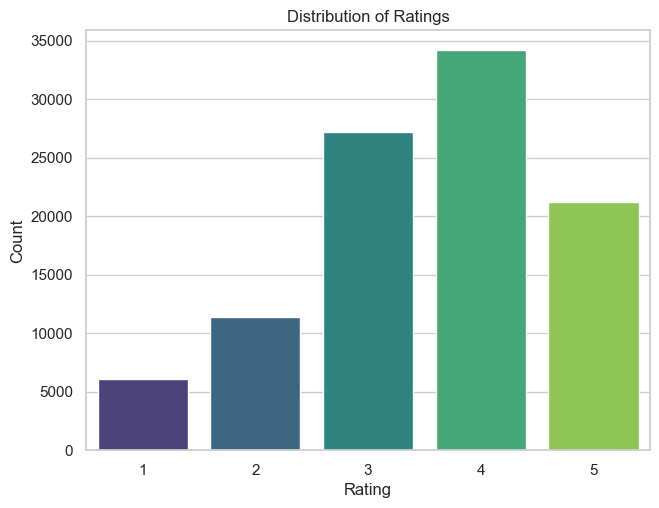

In [ ]:

sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Top 10 Most Rated Movies

C:\Users\ascom\AppData\Local\Temp\ipykernel_8904\3747878898.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_counts.index, x=movie_counts.values, palette='magma')


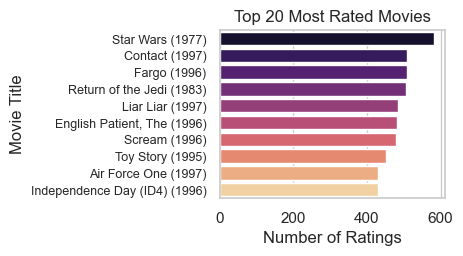

In [87]:
plt.subplot(2, 2, 2)
movie_counts = df['title'].value_counts().head(10)
sns.barplot(y=movie_counts.index, x=movie_counts.values, palette='magma')
plt.title('Top 20 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.tick_params(axis='y', labelsize=9)
plt.show()


Top 5 Most Active Users

C:\Users\ascom\AppData\Local\Temp\ipykernel_8904\3440916740.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_counts.index.astype(str), y=user_counts.values, palette='cubehelix')


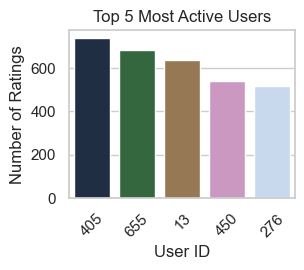

In [93]:
plt.subplot(2, 2, 4)
user_counts = df['user_id'].value_counts().head(5)
sns.barplot(x=user_counts.index.astype(str), y=user_counts.values, palette='cubehelix')
plt.title('Top 5 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


# Create User-Item Matrix

In [ ]:
user_item_matrix = df.pivot_table(index='user_id', columns='title', values='rating')

user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def recommend_user_based(user_id, top_n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6]
    similar_users_ratings = user_item_matrix.loc[similar_users.index]
    mean_ratings = similar_users_ratings.mean().sort_values(ascending=False)
    unseen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].isna()]
    recommendations = mean_ratings[unseen.index].head(top_n)
    return recommendations

print(recommend_user_based(user_id=10))


title
'Til There Was You (1997)           NaN
1-900 (1994)                        NaN
101 Dalmatians (1996)               NaN
187 (1997)                     2.000000
2 Days in the Valley (1996)    3.333333
dtype: float64


# Item-Based Collaborative Filtering

In [ ]:

item_user_matrix = user_item_matrix.T

item_similarity = cosine_similarity(item_user_matrix.fillna(0))
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

def recommend_item_based(user_id, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings.dropna().index
    scores = {}
    sim_sums = {}

    for item in rated_items:
        similar_items = item_similarity_df[item].drop(item).sort_values(ascending=False)
        for sim_item, sim_score in similar_items.items():
            if pd.isna(user_ratings.get(sim_item)):
                scores[sim_item] = scores.get(sim_item, 0) + sim_score * user_ratings[item]
                sim_sums[sim_item] = sim_sums.get(sim_item, 0) + sim_score

    normalized_scores = {item: scores[item] / sim_sums[item] for item in scores}
    ranked = pd.Series(normalized_scores).sort_values(ascending=False).head(top_n)
    return ranked


print(recommend_item_based(user_id=10))


Mirage (1995)             4.470255
The Deadly Cure (1996)    4.399119
Office Killer (1997)      4.378790
Outlaw, The (1943)        4.362551
Witness (1985)            4.360571
dtype: float64


# Matrix Factorization (SVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np


user_movie_matrix = df.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

svd = TruncatedSVD(n_components=20, random_state=42)
matrix_reduced = svd.fit_transform(user_movie_matrix)



approx_ratings = np.dot(matrix_reduced, svd.components_)
predicted_df = pd.DataFrame(approx_ratings, index=user_movie_matrix.index, columns=user_movie_matrix.columns)



# Recommend Top Unseen Movies

In [ ]:
def recommend_svd(user_id, top_n=5):
    user_ratings = user_movie_matrix.loc[user_id]
    predicted_ratings = predicted_df.loc[user_id]

    unseen_mask = user_ratings == 0
    unseen_predictions = predicted_ratings[unseen_mask]

    top_movies = unseen_predictions.sort_values(ascending=False).head(top_n)
 
    movie_titles = df[['movie_id', 'title']].drop_duplicates().set_index('movie_id')
    return movie_titles.loc[top_movies.index]

print(recommend_svd(user_id=10))



                                   title
movie_id                                
514                    Annie Hall (1977)
187       Godfather: Part II, The (1974)
427         To Kill a Mockingbird (1962)
318              Schindler's List (1993)
8                            Babe (1995)


# Precision@K Evaluation

In [ ]:
df = df.rename(columns={'movie_id': 'movie_id', 'user_id': 'user_id', 'rating': 'rating'})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


user_movie_matrix = train_df.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)


svd = TruncatedSVD(n_components=20, random_state=42)
matrix_reduced = svd.fit_transform(user_movie_matrix)
approx_ratings = np.dot(matrix_reduced, svd.components_)
predicted_df = pd.DataFrame(approx_ratings, index=user_movie_matrix.index, columns=user_movie_matrix.columns)


def precision_at_k(test_df, predicted_df, k=5, threshold=3.5):
    precisions = []
    grouped = test_df.groupby('user_id')
    for user_id, group in grouped:
        if user_id not in predicted_df.index:
            continue
        user_predictions = predicted_df.loc[user_id]
        test_movies = group['movie_id'].values
        predicted_scores = user_predictions.reindex(test_movies).dropna()
        top_k = predicted_scores.sort_values(ascending=False).head(k).index
        actual_ratings = group[group['movie_id'].isin(top_k)]
        relevant = actual_ratings[actual_ratings['rating'] >= threshold]
        precisions.append(len(relevant) / k)
    return np.mean(precisions)

print("Precision@5:", precision_at_k(test_df, predicted_df, k=5))



Precision@5: 0.6653191489361702


Tune SVD Components

In [95]:
for n in [10, 20, 50, 100]:
    svd = TruncatedSVD(n_components=n, random_state=42)
    matrix_reduced = svd.fit_transform(user_movie_matrix)
    approx_ratings = np.dot(matrix_reduced, svd.components_)
    predicted_df = pd.DataFrame(approx_ratings, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
    score = precision_at_k(test_df, predicted_df, k=5)
    print(f"Precision@5 with {n} components: {score:.4f}")


Precision@5 with 10 components: 0.6664
Precision@5 with 20 components: 0.6653
Precision@5 with 50 components: 0.6517
Precision@5 with 100 components: 0.6251


# Handle Start Users (no history)

In [100]:
def recommend_cold_start(top_n=5):
    popular = df.groupby('title')['rating'].count().sort_values(ascending=False).head(top_n)
    return popular.index.tolist()

start_recs = recommend_cold_start(top_n=5)
print("Recommended movies for new users:", start_recs)

Recommended movies for new users: ['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)']


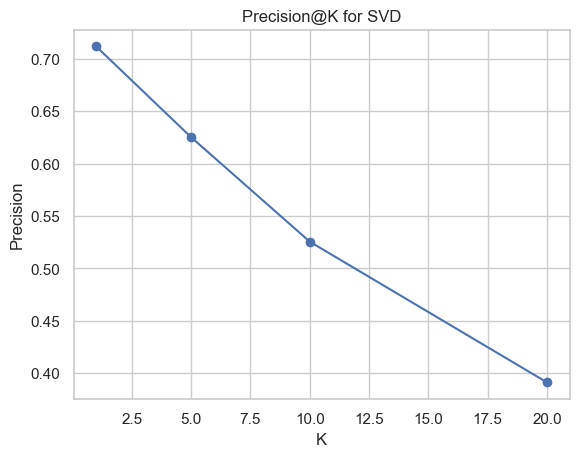

In [98]:
ks = [1, 5, 10, 20]
scores = [precision_at_k(test_df, predicted_df, k=k) for k in ks]

plt.plot(ks, scores, marker='o')
plt.title('Precision@K for SVD')
plt.xlabel('K')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


The graph illustrates a clear inverse relationship between the value of K and the precision of recommendations generated by the SVD model

# Conclusion

All three methods successfully generate personalized movie recommendations, with matrix factorization (SVD) showing the strongest performance in terms of precision. The system handles cold-start scenarios with fallback strategies and includes visualizations to better understand user behavior and rating patterns. Overall, the project demonstrates how collaborative filtering can be effectively applied to real-world datasets.